<a href="https://colab.research.google.com/github/count-im/test/blob/main/2019_ml_month_2nd_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install xgboost==3.0.2 lightgbm==4.6.0 missingno==0.5.2

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [32]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('됐당!')

됐당!


In [33]:
train_data_path = join('../input', 'train.csv')
sub_data_path = join('../input', 'test.csv')

In [58]:
data_dir = '/content/'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/train.csv
/content/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [59]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [60]:
y = data['price']

del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [61]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [38]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

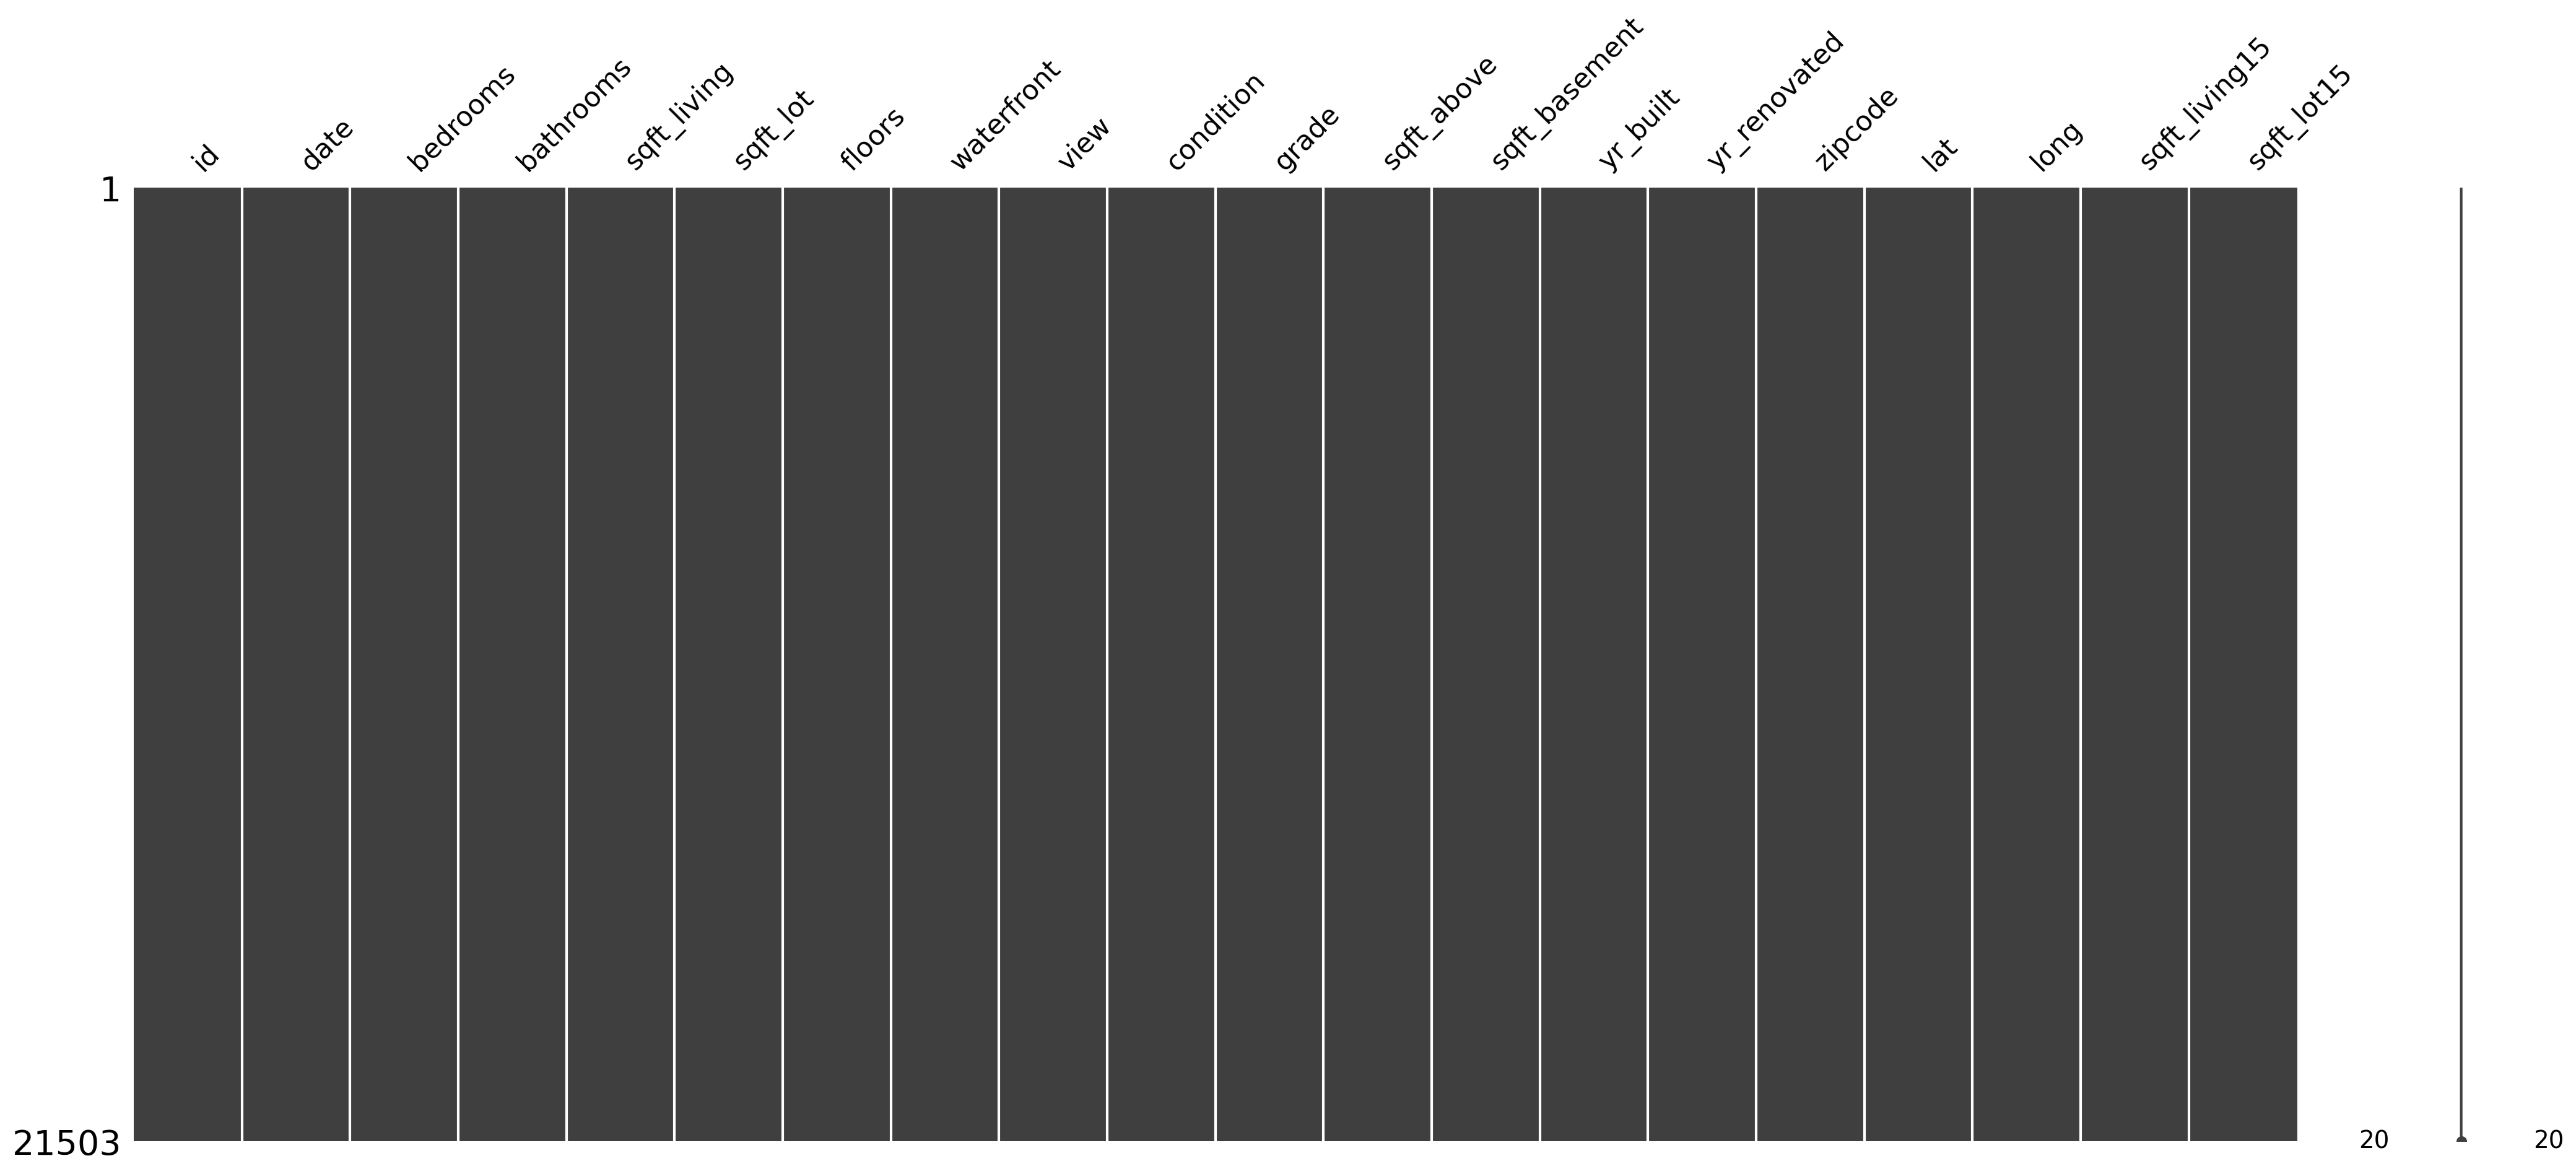

In [39]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [40]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [41]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

,id


In [42]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [43]:
# 한 번에 뿅!
# 추가 : 위에 실행했던 코드는 f-string으로 작동하지만 해당 코드는 대괄호가 2개가 있어 f-string으로 표현하면 에러가 발생합니다. 이럴 경우 format으로 실행합니다.
# 추가에 대한 내용 : https://blockdmask.tistory.com/429
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [44]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [62]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [63]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

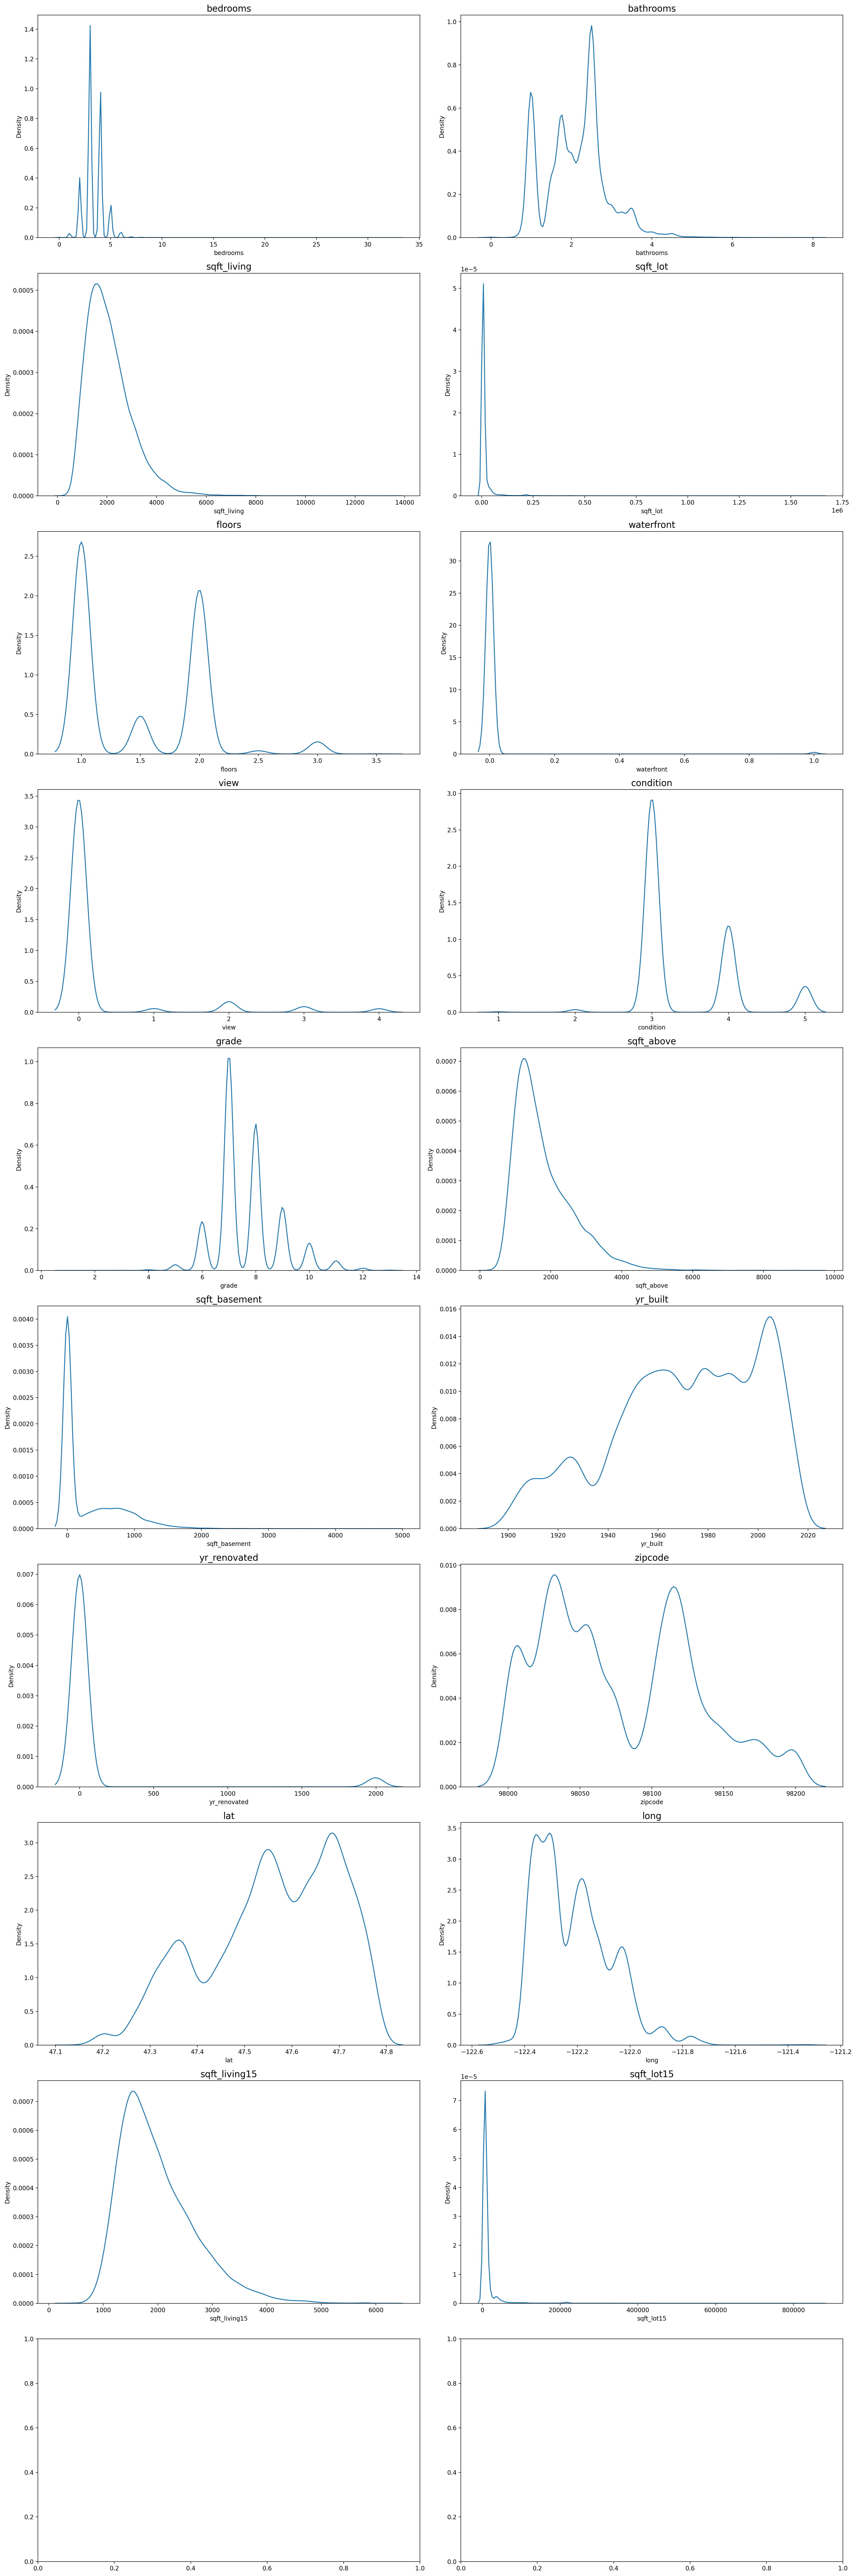

In [47]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# 'date' 컬럼은 범주형 문자열이므로 kdeplot에서 제외합니다.
plot_columns = [col for col in data.columns if col not in ['date']]

count = 0
for row in range(10):
    for col_idx in range(2):
        if count >= len(plot_columns):
            break
        sns.kdeplot(data[plot_columns[count]], ax=ax[row][col_idx])
        ax[row][col_idx].set_title(plot_columns[count], fontsize=15)
        count += 1
    if count >= len(plot_columns):
        break
plt.tight_layout()

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [64]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

    print('다음!!')

다음!!
다음!!
다음!!
다음!!
다음!!


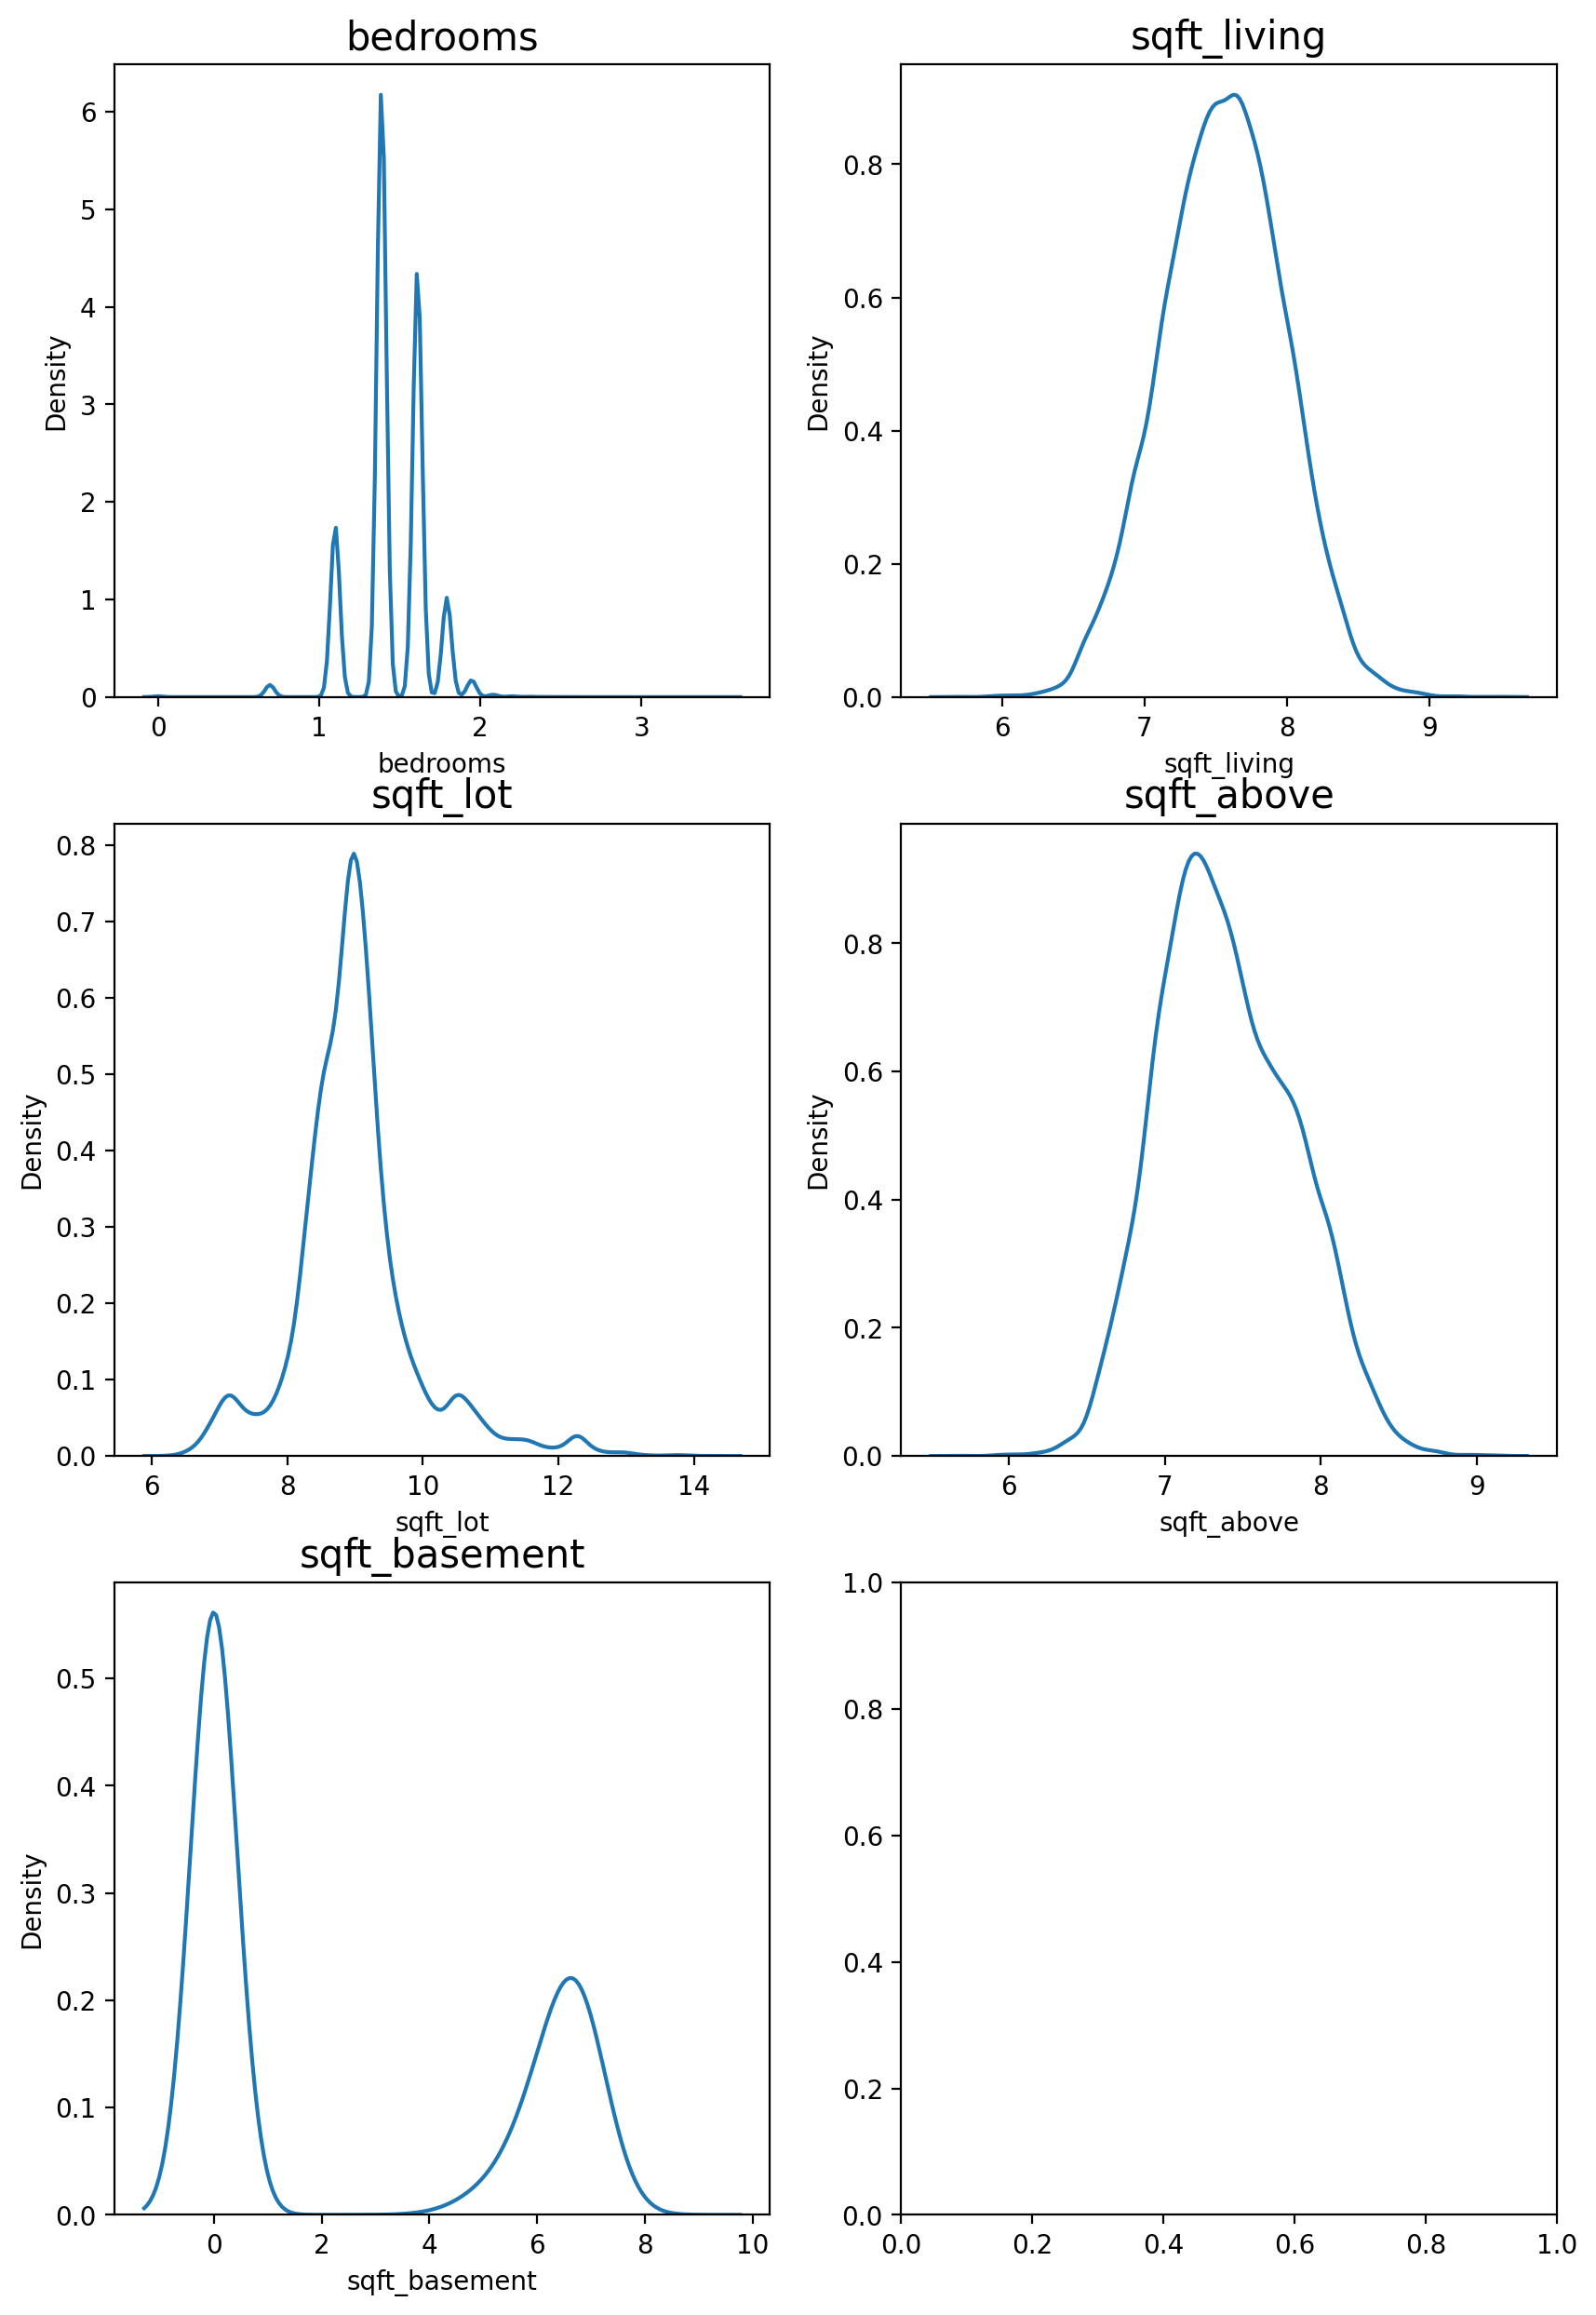

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

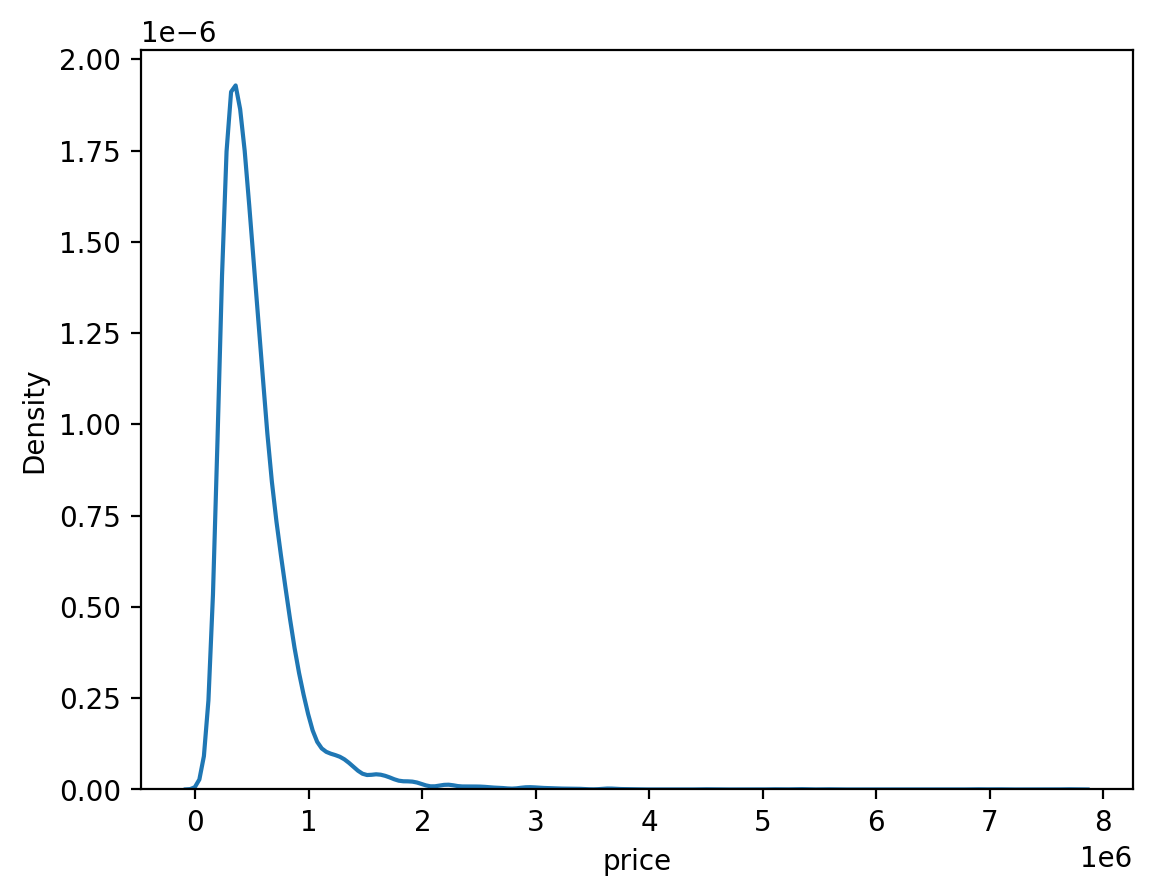

In [50]:
sns.kdeplot(y)
plt.show()

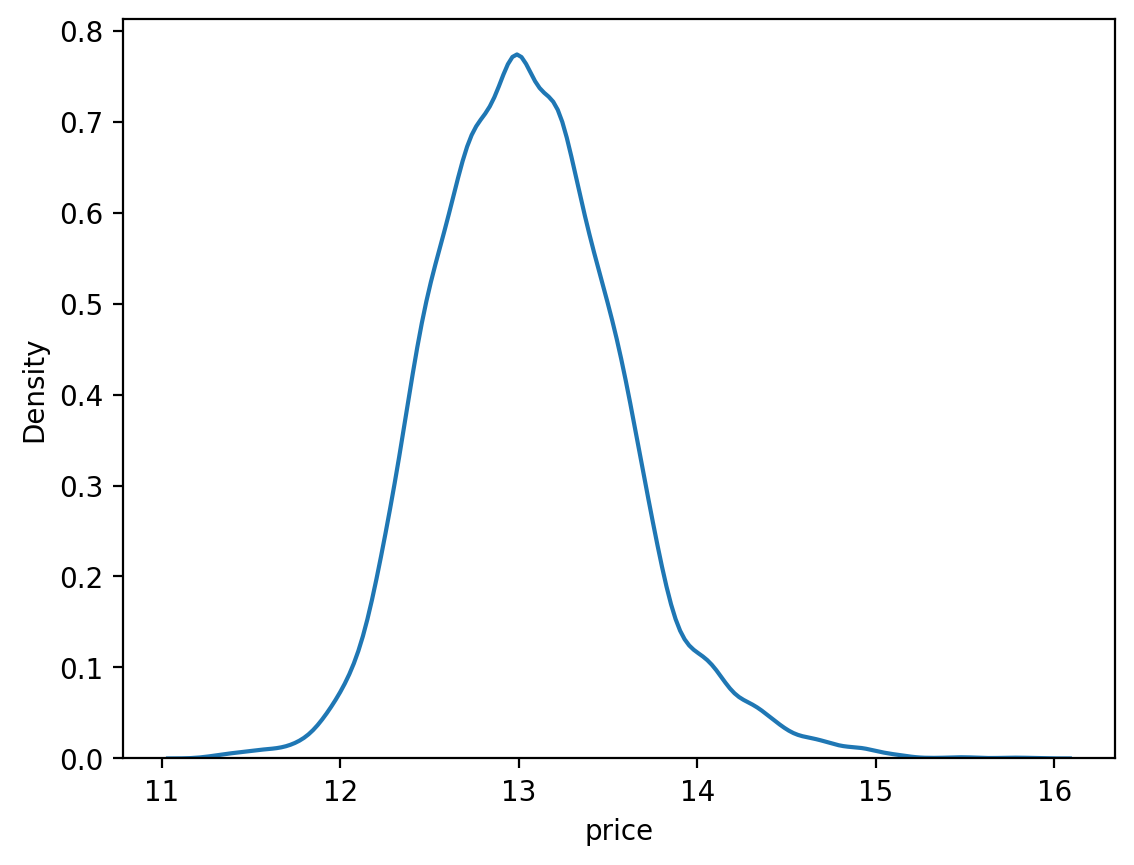

In [65]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [52]:
# The definition of sub and x is moved to the next cell where get_cv_score is called.
# This cell will now be empty or contain comments.

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [66]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('집!!')

집!!


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [67]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y_log_transformation)),
                                             kf=kfold))

In [56]:
get_cv_score(models)

NameError: name 'x' is not defined

In [68]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

get_cv_score(models)

(15035, 19)
(6468, 19)
Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.050187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.052839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [75]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y_log_transformation)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('블렌딩!!')

블렌딩!!


In [77]:
# Ensure 'sub' contains only features, not the submission dataframe
sub_features_for_prediction = data.iloc[train_len:, :]
y_pred = AveragingBlending(models, x, y_log_transformation, sub_features_for_prediction)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


In [78]:
submission_df = pd.DataFrame(data={'id':sub_id,'price':np.expm1(y_pred)})

In [79]:
submission_df.to_csv('submission.csv', index=False)

In [80]:
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,13.142006
1,15036,12.969722
2,15037,14.116700
3,15038,12.671415
4,15039,12.675806


In [81]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/submission.csv


=============================================

In [82]:
train_data_path = join('../input', 'train.csv')
sub_data_path = join('../input', 'test.csv')

In [83]:
data_dir = '/content/'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/train.csv
/content/test.csv


In [87]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

In [88]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [89]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [90]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [91]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [92]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [93]:
y

,price
0,221900.0
1,180000.0
2,510000.0
3,257500.0
4,291850.0
...,...
15030,610685.0
15031,1007500.0
15032,360000.0
15033,400000.0


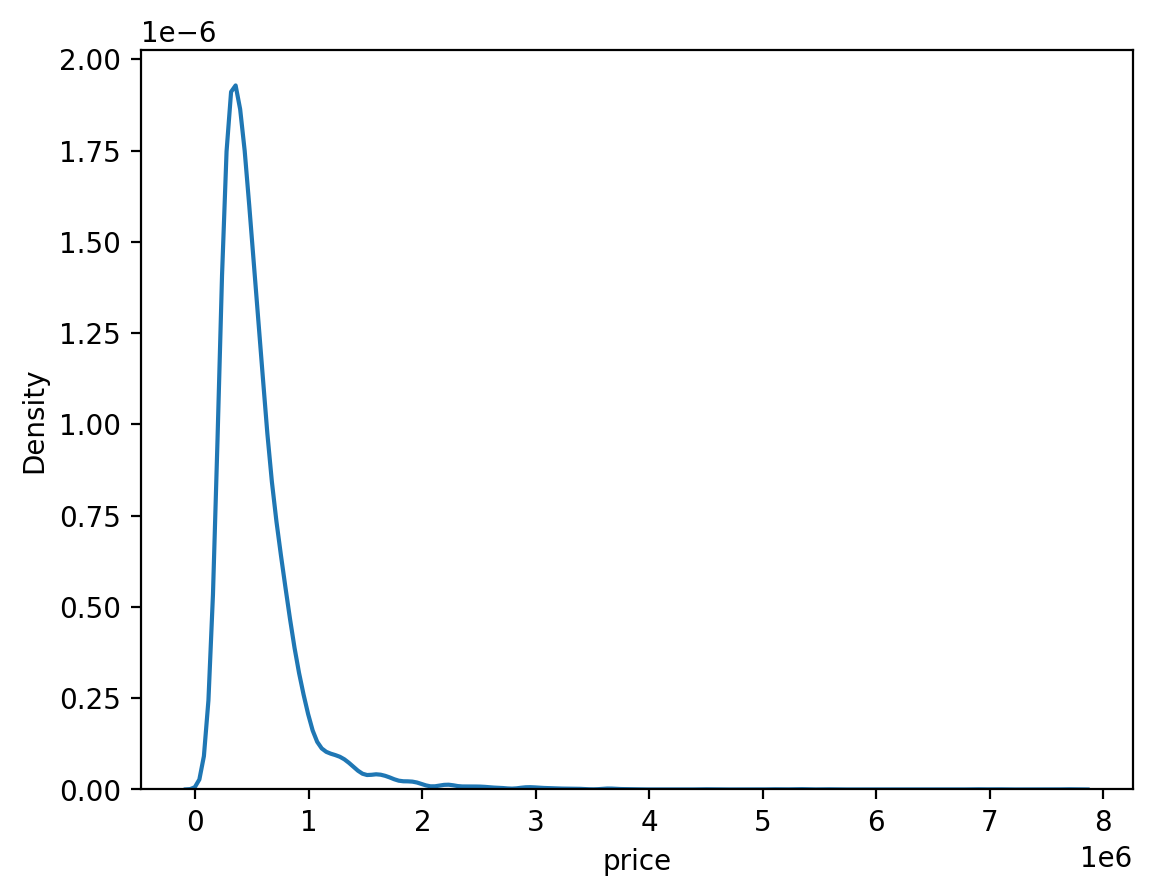

In [94]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""

#코드 작성
sns.kdeplot(y)
plt.show()

In [95]:
y = np.log1p(y)
y

,price
0,12.309987
1,12.100718
2,13.142168
3,12.458779
4,12.583999
...,...
15030,13.322338
15031,13.822984
15032,12.793862
15033,12.899222


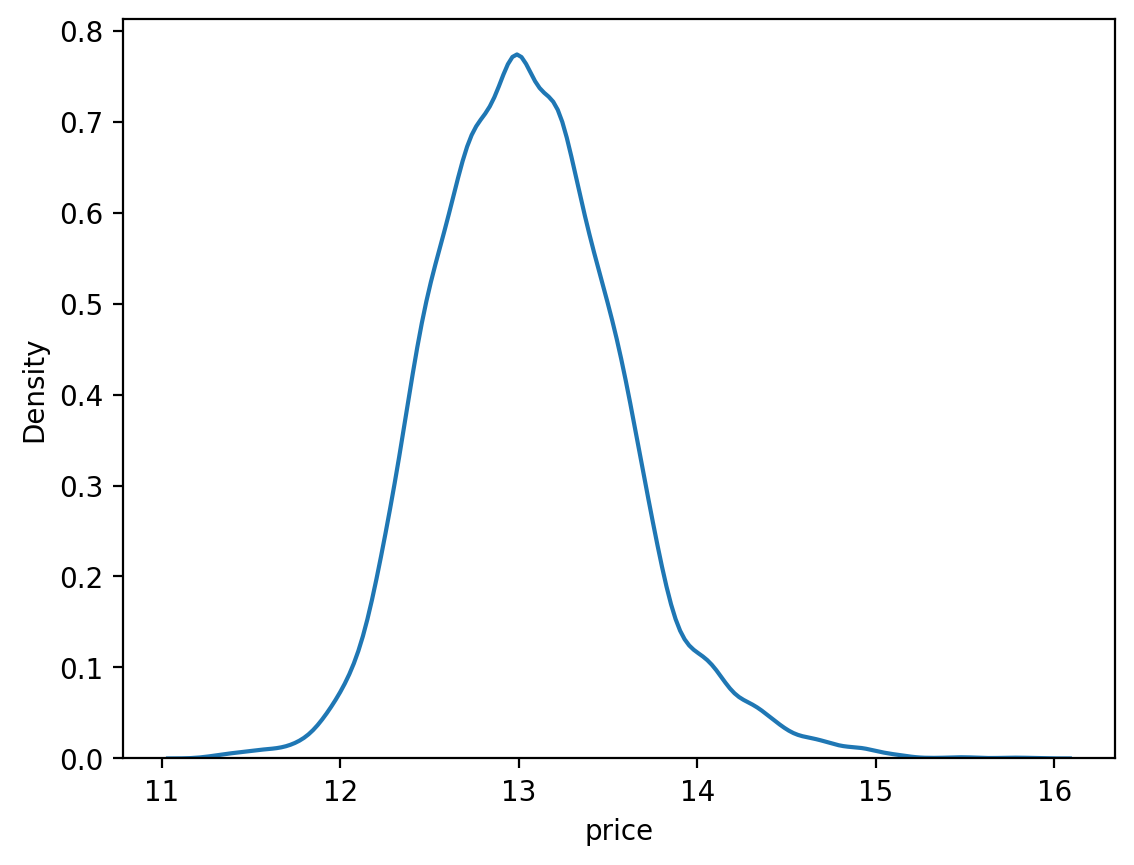

In [96]:
sns.kdeplot(y)
plt.show()

In [97]:
y = np.log1p(y)
y

,price
0,2.588515
1,2.572667
2,2.649161
3,2.599632
4,2.608893
...,...
15030,2.661820
15031,2.696179
15032,2.624224
15033,2.631833


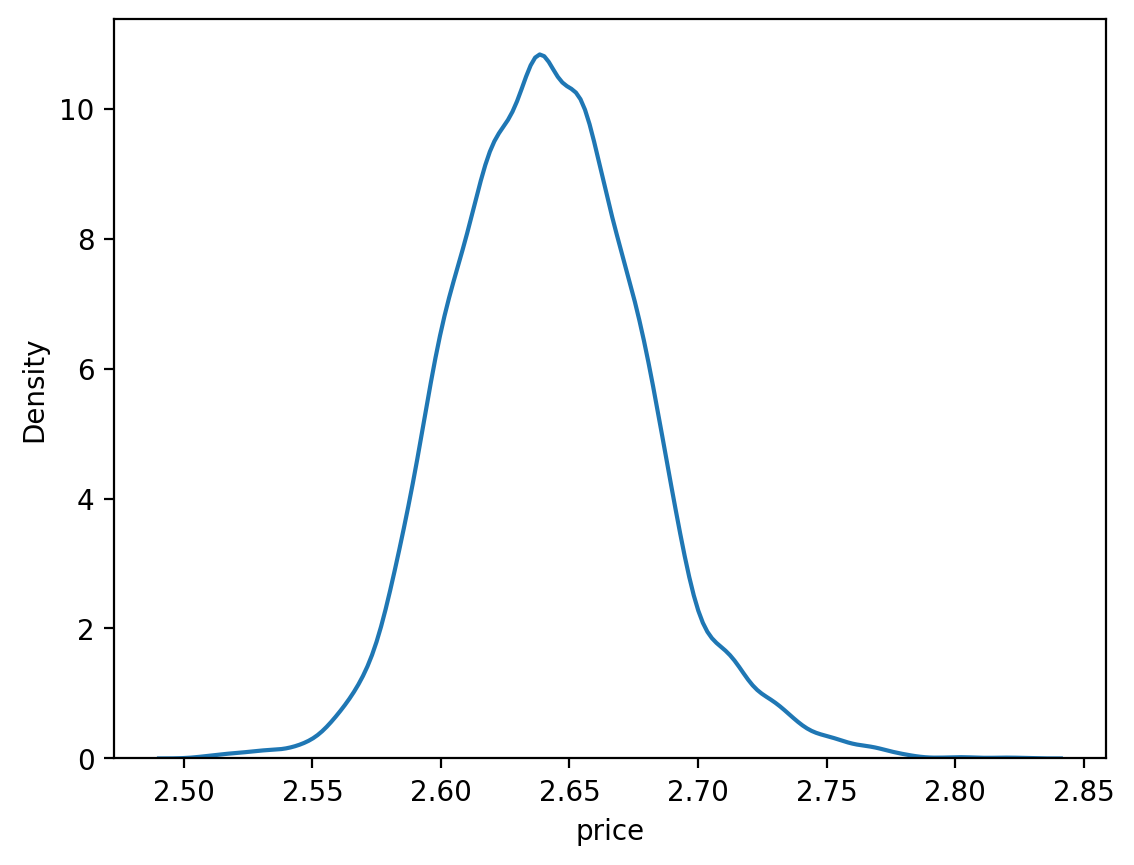

In [98]:
sns.kdeplot(y)
plt.show()

In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('준비!!')

준비!!


In [101]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('모라구?!!')

모라구?!!


In [103]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('regressor!!')

regressor!!


In [104]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('랜덤!!')

랜덤!!


In [105]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [106]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)


    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)

    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 2.641764


{'GradientBoostingRegressor': np.float64(0.1809232218184817),
 'XGBRegressor': np.float64(0.16787828473162153),
 'LGBMRegressor': np.float64(0.16314856105233844),
 'RandomForestRegressor': np.float64(0.1772598365624751)}

In [107]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [108]:
from sklearn.model_selection import GridSearchCV

print('실험!!')

실험!!


In [110]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [111]:
model = LGBMRegressor(random_state=random_state)

print('LGBM!!')

LGBM!!


In [112]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 2.641790


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [113]:
grid_model.cv_results_

{'mean_fit_time': array([0.33061976, 0.45846534, 0.80525656, 1.04703326]),
 'std_fit_time': array([0.04873288, 0.07343653, 0.1300778 , 0.03576977]),
 'mean_score_time': array([0.02424574, 0.03462553, 0.06012964, 0.06201968]),
 'std_score_time': array([0.00611344, 0.009295  , 0.00791432, 0.02065524]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014791, -0.00013679]),
 'split1_test_score': array([-0.00038423, -0.00029197, -0.00015652, -0.00014476]),
 'split2_test_score': array([-0.00037037, -0.00028103, -0.00015901, -0.00014852]),
 'spl

In [114]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [115]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.00036765, -0.00027737, -0.00015077, -0.00014011])

In [116]:
# 여기에 코드를 작성하세요.


results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.000368
1,1,100,-0.000277
2,10,50,-0.000151
3,10,100,-0.000140


In [117]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [118]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [119]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011837
2,10,50,-0.000151,0.012279
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174


In [122]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 2.641790


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011837
2,10,50,-0.000151,0.012279
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174


In [123]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 2.641790


array([2.64364262, 2.64014739, 2.71797999, ..., 2.6413381 , 2.61577285,
       2.63572556])

In [124]:
prediction = np.expm1(prediction)
prediction

array([13.06434146, 13.01526921, 14.14968879, ..., 13.03196719,
       12.67778315, 12.95343288])

In [126]:
data_dir = '/content/'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [127]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,13.064341
1,15036,13.015269
2,15037,14.149689
3,15038,12.673338
4,15039,12.704526


In [128]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content//submission_lgbm_RMSLE_0.164399.csv


In [134]:
"""
감독 아래, `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/'  # Corrected data_dir to point to /content/
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [135]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 2.641790
/content//submission_lgbm_RMSLE_0.164399.csv saved!


=================================================

In [136]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

3.0.2
4.6.0
0.5.2
1.5.2


In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
train = pd.read_csv('/content/train.csv')
test  = pd.read_csv('/content/test.csv')

In [139]:
print(train.shape, test.shape)
train.head()

(15035, 21) (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [140]:
train.columns


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [150]:
target_col = "price"

id_candidates = [c for c in test.columns if c.lower() in ["id", "index"]]
id_col = id_candidates[0] if len(id_candidates) else test.columns[0]
print("id_col:", id_col, "target_col:", target_col)

y = train[target_col]
X = train.drop(columns=[target_col, id_col])
test_X = test.drop(columns=[id_col]).copy()

# Convert date and zipcode to categorical type explicitly
X['date'] = X['date'].astype('category')
X['zipcode'] = X['zipcode'].astype('category')
test_X['date'] = test_X['date'].astype('category')
test_X['zipcode'] = test_X['zipcode'].astype('category')

id_col: id target_col: price


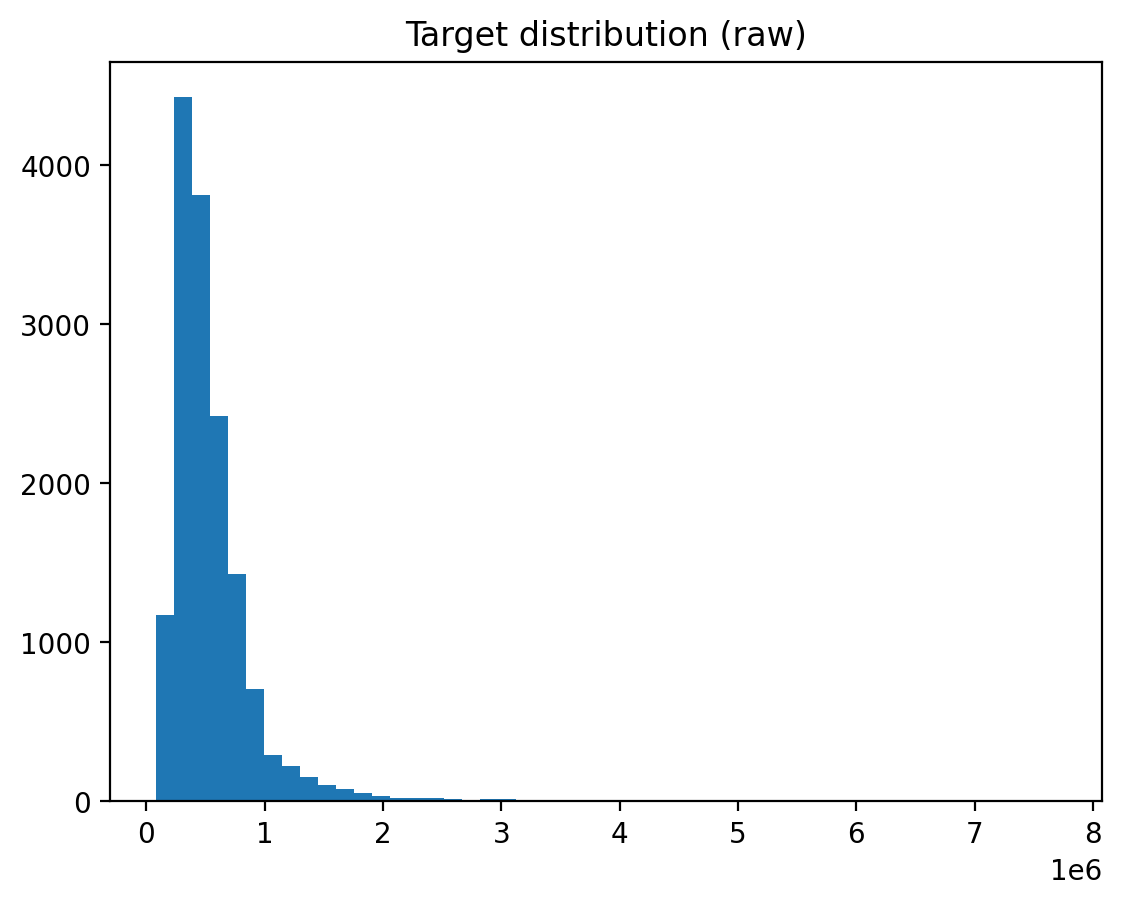

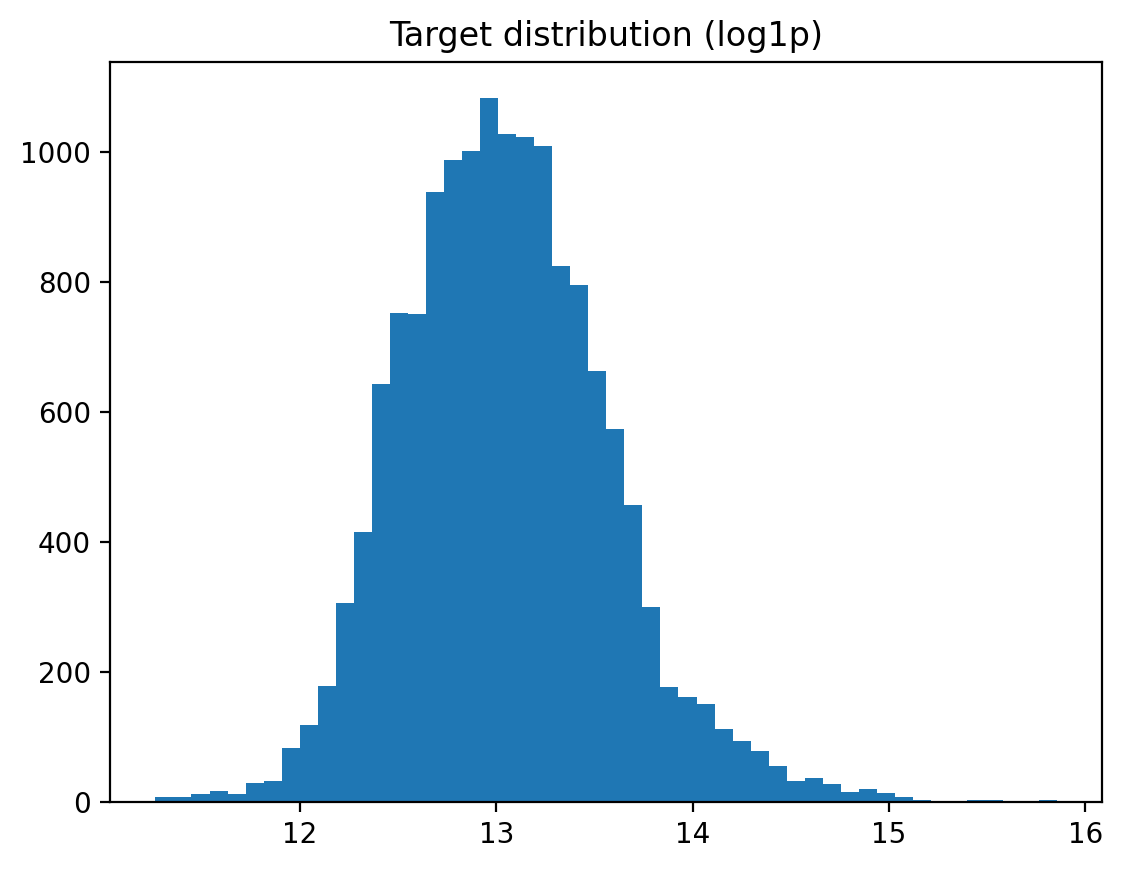

In [145]:
plt.figure()
plt.hist(y, bins=50)
plt.title("Target distribution (raw)")
plt.show()

y_log = np.log1p(y)

plt.figure()
plt.hist(y_log, bins=50)
plt.title("Target distribution (log1p)")
plt.show()


In [151]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Use the modified X and test_X which have 'date' and 'zipcode' as 'category' dtype
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
)

In [152]:
def cv_mae(model, X, y_log, column_transformer_instance, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    maes = []

    # Fit the ColumnTransformer once on the entire X dataset before the KFold loop
    # This ensures a consistent number of features from OneHotEncoder across all folds
    column_transformer_instance.fit(X)

    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y_log.iloc[tr_idx], y_log.iloc[va_idx]

        # Transform training and validation data using the pre-fitted ColumnTransformer
        X_tr_processed = column_transformer_instance.transform(X_tr)
        X_va_processed = column_transformer_instance.transform(X_va)

        # Fit the model directly on the processed data
        model.fit(X_tr_processed, y_tr)
        pred_log = model.predict(X_va_processed)

        mae = mean_absolute_error(np.expm1(y_va), np.expm1(pred_log))
        maes.append(mae)

    return float(np.mean(maes)), float(np.std(maes))

In [153]:
from lightgbm import LGBMRegressor

baseline_model = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

baseline_mean, baseline_std = cv_mae(baseline_model, X, y_log, preprocess)
print("Baseline CV MAE:", baseline_mean, "+/-", baseline_std)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2861
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 341
[LightGBM] [Info] Start training from score 13.047364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2891
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 341
[LightGBM] [Info] Start training from score 13.049396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 344
[LightGBM] [Info] Star

In [154]:
tuned_model = LGBMRegressor(
    n_estimators=7000,
    learning_rate=0.01,

    num_leaves=64,
    max_depth=-1,
    min_child_samples=20,

    subsample=0.7,
    subsample_freq=1,
    colsample_bytree=0.7,

    reg_alpha=0.1,
    reg_lambda=0.3,

    random_state=42
)

tuned_mean, tuned_std = cv_mae(tuned_model, X, y_log, preprocess)
print("Tuned CV MAE:", tuned_mean, "+/-", tuned_std)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2861
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 341
[LightGBM] [Info] Start training from score 13.047364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2891
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 341
[LightGBM] [Info] Start training from score 13.049396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 344
[LightGBM] [Info] Star

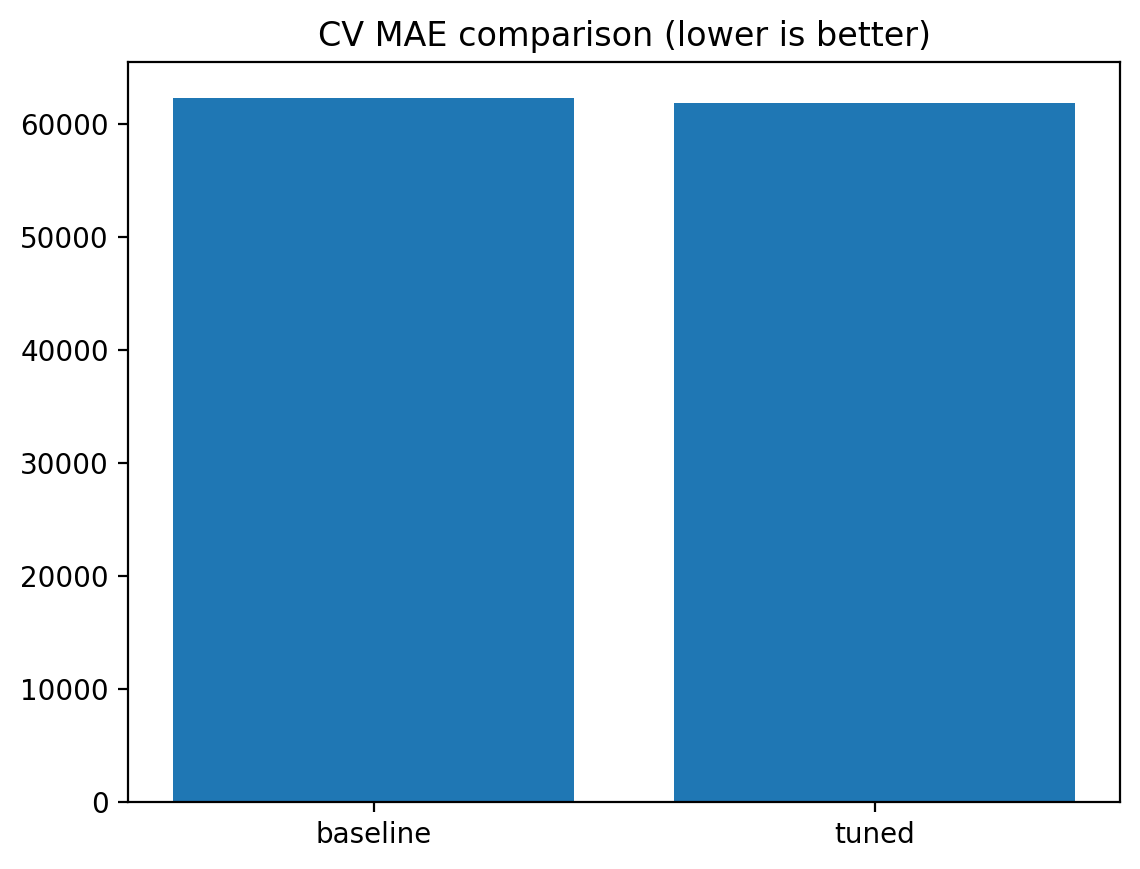

baseline_mean: 62304.6848909642
tuned_mean   : 61830.81064389469


In [155]:
plt.figure()
plt.bar(["baseline", "tuned"], [baseline_mean, tuned_mean])
plt.title("CV MAE comparison (lower is better)")
plt.show()

print("baseline_mean:", baseline_mean)
print("tuned_mean   :", tuned_mean)


In [156]:
final_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", tuned_model),
])

final_pipe.fit(X, y_log)

test_pred_log = final_pipe.predict(test_X)
test_pred = np.expm1(test_pred_log)

submission = pd.DataFrame({
    id_col: test[id_col],
    target_col: test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 347
[LightGBM] [Info] Start training from score 13.048122


,id,price
0,15035,5.058595e+05
1,15036,4.973342e+05
2,15037,1.334841e+06
3,15038,2.932719e+05
4,15039,3.160349e+05
